<a href="https://colab.research.google.com/github/DennisChangach/Recommender-Systems/blob/main/Task_2_Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Movie Recommender System

Recommendation systems have a strong influence on our decisions. Recommendation systems are  a type of information filtering systems as they improve the quality of search results and provides items that are more relevant to the search item or related to the search history of the user.

They are used to predict the rating or preference that a user would give to an item. Companies like Netfix depend highly on the effectiveness of their recommendation engines to drive business value.

This notebook will be using the MovieLens dataset to build a movie recommendation system.

**The main types of recommender systems are:**

1. Content Based Filtering: They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

2. Collaborative Filtering: This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based counterparts.Collaborative filtering methods predict the target user’s rating of a given item using similar users’ ratings of that item.

Collaborative filtering is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand(from an overall implementation perspective)

For more details check out this article [here.](https://https://medium.com/@jwu2/types-of-recommender-systems-9cc216294802)


Dataset

The dataset used in this notebook is from MovieLens, a movie rating dataset. The dataset will be used to develop a basic movie recommendation system using collaborative filtering.

Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#installing necessary depedencies
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 5.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670905 sha256=9d2416dd0897290e01d9406ee9fdd61c957e040f31fc230944d68fe8184e780d
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [4]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from collections import defaultdict


Loading the Datasets

In [5]:
#loading the datasets
file_path = '/content/drive/My Drive/Sancom Interview Assessment/Task_2/Datasets/ratings.csv'
ratings_df = pd.read_csv(file_path)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
#getting the general info on the ratings dataframe
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
#loading the movie titles
file_path_1 = '/content/drive/My Drive/Sancom Interview Assessment/Task_2/Datasets/movies.csv'
movie_titles = pd.read_csv(file_path_1)
movie_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
#getting info on titles dataframe
movie_titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [9]:
#merging the dataframes
merged_df = pd.merge(ratings_df,movie_titles,on='movieId')
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Exploratory Data Analysis(EDA)

The Average rating of Movie Titles

In [10]:
#grouping the merged dataframe by title_The top 10 rated movies
merged_df.groupby('title')['rating'].mean().sort_values(ascending = False).head(10)

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Sorority House Massacre (1986)                   5.0
Bill Hicks: Revelations (1993)                   5.0
My Man Godfrey (1957)                            5.0
Hellbenders (2012)                               5.0
In the blue sea, in the white foam. (1984)       5.0
Name: rating, dtype: float64

In [11]:
#The most rated movies
merged_df.groupby('title')['rating'].count().sort_values(ascending=False).head(20)

title
Forrest Gump (1994)                                                               329
Shawshank Redemption, The (1994)                                                  317
Pulp Fiction (1994)                                                               307
Silence of the Lambs, The (1991)                                                  279
Matrix, The (1999)                                                                278
Star Wars: Episode IV - A New Hope (1977)                                         251
Jurassic Park (1993)                                                              238
Braveheart (1995)                                                                 237
Terminator 2: Judgment Day (1991)                                                 224
Schindler's List (1993)                                                           220
Fight Club (1999)                                                                 218
Toy Story (1995)                                

In [12]:
#creating a dataframe- grouped by the title
grouped_df = pd.DataFrame(merged_df.groupby('title')['rating'].mean())
grouped_df.head(10)

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
'Tis the Season for Love (2015),1.500000
"'burbs, The (1989)",3.176471
'night Mother (1986),3.000000
(500) Days of Summer (2009),3.666667


In [13]:
#getting the number of ratings per movie title
grouped_df['num_of_ratings'] = pd.DataFrame(merged_df.groupby('title')['rating'].count())
grouped_df.head(10)

,rating,num_of_ratings
title,,
'71 (2014),4.000000,1
'Hellboy': The Seeds of Creation (2004),4.000000,1
'Round Midnight (1986),3.500000,2
'Salem's Lot (2004),5.000000,1
'Til There Was You (1997),4.000000,2
'Tis the Season for Love (2015),1.500000,1
"'burbs, The (1989)",3.176471,17
'night Mother (1986),3.000000,1
(500) Days of Summer (2009),3.666667,42


In [14]:
#average number of ratings
grouped_df['num_of_ratings'].mean()

10.375141475460438

In [15]:
#number of movies with more than average number of ratings
sum(grouped_df['num_of_ratings']>10)

2121

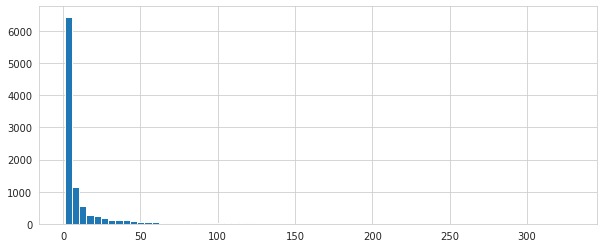

In [16]:
#Distribution of num of ratings
plt.figure(figsize = (10,4))
grouped_df['num_of_ratings'].hist(bins=70)

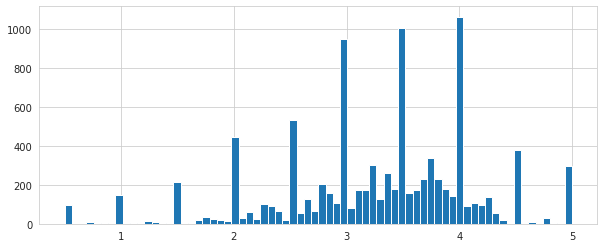

In [17]:
#Distribution of ratings
plt.figure(figsize=(10,4))
grouped_df['rating'].hist(bins=70)
plt.show()

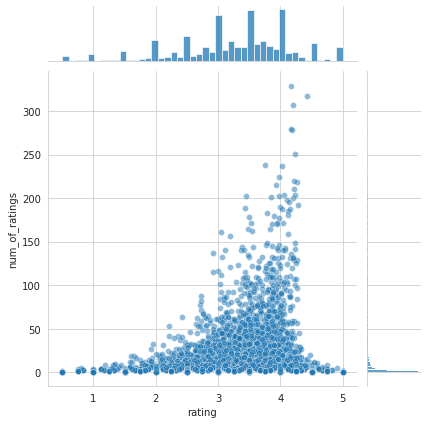

In [18]:
#distribution of ratings against number of ratings
sns.jointplot(x='rating',y='num_of_ratings',data=grouped_df,alpha=0.5)

From the above plot we can infer most of the movies are rated between 3 and 4. While movies with the highest ratings do not have the most number of ratings

In [19]:
#number of ratings per user
merged_df.groupby('userId')['rating'].count().sort_values(ascending=False).head(10)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: rating, dtype: int64

In [20]:
#number of ratings per user
merged_df.groupby('userId')['rating'].count().sort_values(ascending=True).head(10)

userId
442    20
406    20
147    20
194    20
569    20
576    20
431    20
207    20
278    20
320    20
Name: rating, dtype: int64

The minumum number of ratings given by a user is 20 while the highest number of ratings is 2698. 

## Building a Recommender System

### **Part One: Using Pandas**

Having a general idea of what the data looks like, a simple recommendation system can be built using pandas.

In [21]:
#creating a matrix
matrix = merged_df.pivot_table(index='userId',columns='title',values='rating')
matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Grabbing the user ratings for some of the most rated movies. 


 Star Wars: Episode IV - A New Hope (1977) -      A sci-fi movie

In [22]:
#getting the ratings
Forrest_ratings = matrix['Forrest Gump (1994)']
Star_ratings = matrix['Star Wars: Episode IV - A New Hope (1977)']

Star_ratings.head()

userId
1    5.0
2    NaN
3    NaN
4    5.0
5    NaN
Name: Star Wars: Episode IV - A New Hope (1977), dtype: float64

Corrwith(), method can be used to get the correlations between the two panda series.

In [23]:
#getting the similarities
similar_to_Stars = matrix.corrwith(Star_ratings)


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [24]:
#removing NaN values
corr_starwars = pd.DataFrame(similar_to_Stars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
"'burbs, The (1989)",0.155161
(500) Days of Summer (2009),0.024299
*batteries not included (1987),-0.269069
10 Cent Pistol (2015),1.000000
10 Cloverfield Lane (2016),0.360885


In [25]:
#sorting the correlation dataframe to get the most similar movies
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Lakeview Terrace (2008),1.0
Cry_Wolf (a.k.a. Cry Wolf) (2005),1.0
Creep (2014),1.0
Non-Stop (2014),1.0
Not Without My Daughter (1991),1.0
Confessions of a Teenage Drama Queen (2004),1.0
Concussion (2015),1.0
Opera (1987),1.0
Our Hospitality (1923),1.0


Some results clearly do not make sense such as Confessions of a Teenage Drama queen if selected by genre. This is because there are a lot of movies on;y watched bonce by isers who also watched star wars-given it is a popular movie.

This can be fixed by filtering out the movies that have less than 100 reviews.



In [26]:
corr_starwars = corr_starwars.join(grouped_df['num_of_ratings'])
corr_starwars.head()


,Correlation,num_of_ratings
title,,
"'burbs, The (1989)",0.155161,17
(500) Days of Summer (2009),0.024299,42
*batteries not included (1987),-0.269069,7
10 Cent Pistol (2015),1.000000,2
10 Cloverfield Lane (2016),0.360885,14


In [27]:
#filtering out the movies with less than 100 number of ratings
corr_starwars[corr_starwars['num_of_ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num_of_ratings
title,,
Star Wars: Episode IV - A New Hope (1977),1.000000,251
Star Wars: Episode V - The Empire Strikes Back (1980),0.777970,211
Star Wars: Episode VI - Return of the Jedi (1983),0.734230,196
"Fugitive, The (1993)",0.482078,190
Indiana Jones and the Last Crusade (1989),0.410916,140


The recommendation here makes a lot of sense, compared to the earlier result. We can therefore create a function where on passing the name of the movie we can get movie recommendations.

In [28]:
#defining the function returns top 5 recommendations
def movie_recommender(movie_title):
  #getting the movie ratings
  movie_ratings = matrix[movie_title]
  #getting movies similar to the movie title
  similar_to_movie = matrix.corrwith(movie_ratings)
  #creating a dataframe
  corr_movie = pd.DataFrame(similar_to_movie,columns=['Correlation'])
  #removing NaN values
  corr_movie.dropna(inplace=True)
  #getting the number of ratings per movie title
  corr_movie = corr_movie.join(grouped_df['num_of_ratings'])
  #filtering for movie title with more than 20 ratings
  return corr_movie[corr_movie['num_of_ratings']>100].sort_values('Correlation',ascending=False).head(6)


In [29]:
# Recommendation for 'Pulp Fiction'
movie_recommender('Pulp Fiction (1994)')

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
Pulp Fiction (1994),1.000000,307
Fight Club (1999),0.543465,218
Kill Bill: Vol. 1 (2003),0.504147,131
Trainspotting (1996),0.437714,102
Kill Bill: Vol. 2 (2004),0.421685,110
"Usual Suspects, The (1995)",0.411700,204


From the above results, the recommender system seems to be quite accurate. The movies recommended are of from the same genre and others are by the same Director! Quentin Tarantino!

In [30]:
# Recommendation for 'Toy Story (1995)'
movie_recommender('Toy Story (1995)')

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
Toy Story (1995),1.000000,215
"Incredibles, The (2004)",0.643301,125
Finding Nemo (2003),0.618701,141
Aladdin (1992),0.611892,183
"Monsters, Inc. (2001)",0.490231,132
Mrs. Doubtfire (1993),0.446261,144


The system has recommended the same genre- Animation. The recommender seems to be performing well.

In [31]:
# Recommendation for 'Lord of the Rings: The Fellowship of the Ring, The (2001))'
movie_recommender('Lord of the Rings: The Fellowship of the Ring, The (2001)')

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation,num_of_ratings
title,,
"Lord of the Rings: The Fellowship of the Ring, The (2001)",1.000000,198
"Lord of the Rings: The Two Towers, The (2002)",0.887301,188
"Lord of the Rings: The Return of the King, The (2003)",0.849939,185
Indiana Jones and the Last Crusade (1989),0.440996,140
Alien (1979),0.396209,146
Outbreak (1995),0.393474,101


The recommender seems to perform, well here too. However this method is not as robust therefore the is need to use other advanced models.

### **Part 2: Using Surprise**

[Surprise](https://http://surpriselib.com/) is a python scikit for building and analyzing recommender systems that deal with explicit rating data.

Surprise has a set of builtin datasets, but one can still use a custom dataset. Loading a rating dataset can either be done from a file or a pandas dataframe. One needs to define a Reader object for Surprise to be able to parse the file or dataframe.

Check [here ](https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset)for more details:

In [32]:
#ratings dataset
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [81]:
#creating the dataframe to be used with Surprise
ratings_dict = {'userID': list(ratings_df.userId),
                'itemID': list(ratings_df.movieId),
                'rating': list(ratings_df.rating)}

df = pd.DataFrame(ratings_dict)
df.head()

,userID,itemID,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [82]:
#creating a reader object only with the rating scale parameter
reader = Reader(rating_scale=(0.5, 5.0))
#loading the dataset from pandas dataframe
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)




Surprise provides a bunch of built-in algorithms.Some algorithms may use baseline estimates while some may use similarity measure. These are the algorithms whose performance will be compared. RMSE is used as the accuracy metric for the predictions.

**1: Normal Predictor:** It predicts a random rating based on the distribution of the training set, which is assumed to be normal.
It's a basic algorithm that does not do much work but that is still useful for comparing accuracies.

**2: SVD:** It got popularized by Simon Funk during the Netflix prize and is a Matrix Factorized algorithm. If baselines are not used, it is equivalent to PMF.

**3: NMF:** It is based on Non-negative matrix factorization and is similar to SVD.

**4: KNN Basic:** This is a basic collaborative filtering algorithm method.

In [83]:
#developing a benchmark
benchmark = []

for algo in [SVD(),NMF(),NormalPredictor(),KNNBasic()]:
  #performing cross validation
  results = cross_validate(algo,data,measures=['RMSE'],cv=3,verbose = False)

  #Getting the results
  tmp = pd.DataFrame.from_dict(results).mean(axis=0)
  tmp = tmp.append(pd.Series([str(algo).split(' ')[0].split('.')[-1]],index=['Algorithm']))
  benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [84]:
# converting the results into a dataframe
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.880395,4.317067,0.337731
NMF,0.936479,4.986980,0.238970
KNNBasic,0.958886,0.098997,2.267735
NormalPredictor,1.429247,0.105222,0.351722


As seen from the above table, SVD has the least RMSE value. Therefore the next step is to tune the hyperparameters of SVD

**Hyperparameter Tuning**

The defualt parameters for SVD are:
1. n_factors = 100 - The number of factors.
2. n_epocs = 20 - The number of iterations of the Stochastic Gradient Descent(SGD) procedure
3. lr_all =0.005 -  The learning rate for all the parameters.
4. reg_all = 0.02 - The regularization term for all parameters.



The cross_validate() function reports accuracy metric over a cross-validation procedure for a given set of parameters. If you want to know which parameter combination yields the best results, the GridSearchCV class comes to the rescue. Given a dict of parameters, this class exhaustively tries all the combinations of parameters and reports the best parameters for any accuracy measure (averaged over the different splits). It is heavily inspired from scikit-learn’s GridSearchCV. - From documentation

In [85]:
#Hyperparameter tuning using GridSearchCV
#dictionary of parameters
param_grid = {'n_factors': [25, 30, 35, 40], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],
              'reg_all': [0.08, 0.1, 0.15]}
# with three crossfolds
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
#fitting the data
gs.fit(data)
#checking the results
results_df = pd.DataFrame.from_dict(gs.cv_results)


In [86]:
results_df.sort_values('mean_test_rmse',ascending = True).head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
69,0.869751,0.868640,0.865935,0.868108,0.001602,1,0.669103,0.666056,0.665602,0.666920,0.001554,1,2.429219,0.007937,0.274189,0.077480,"{'n_factors': 30, 'n_epochs': 25, 'lr_all': 0....",30,25,0.008,0.08
141,0.870977,0.868100,0.866480,0.868519,0.001860,2,0.669859,0.665981,0.666227,0.667356,0.001773,2,2.843388,0.007694,0.283715,0.098592,"{'n_factors': 40, 'n_epochs': 25, 'lr_all': 0....",40,25,0.008,0.08
33,0.869974,0.868798,0.868542,0.869105,0.000624,3,0.669154,0.666753,0.667712,0.667873,0.000987,3,2.223670,0.004069,0.270496,0.079822,"{'n_factors': 25, 'n_epochs': 25, 'lr_all': 0....",25,25,0.008,0.08
142,0.871229,0.870247,0.867203,0.869560,0.001714,4,0.670258,0.668230,0.667179,0.668556,0.001278,6,2.839108,0.007909,0.273345,0.081560,"{'n_factors': 40, 'n_epochs': 25, 'lr_all': 0....",40,25,0.008,0.10
106,0.871031,0.869912,0.868020,0.869654,0.001243,5,0.670472,0.667517,0.667646,0.668545,0.001364,5,2.826410,0.049261,0.289811,0.067904,"{'n_factors': 35, 'n_epochs': 25, 'lr_all': 0....",35,25,0.008,0.10


In [87]:
#best MRMSE score
print(gs.best_score['rmse'])
#combination of parameters that give the best RMSE score
print(gs.best_params['rmse'])
#algorithm with best RMSE
algo = gs.best_estimator['rmse']

0.8681084677236107
{'n_factors': 30, 'n_epochs': 25, 'lr_all': 0.008, 'reg_all': 0.08}


In [88]:
#Assigning values
t = gs.best_params
factors = t['rmse']['n_factors']
epochs = t['rmse']['n_epochs']
lr_value = t['rmse']['lr_all']
reg_value = t['rmse']['reg_all']

**Training & Testing**

With the right set of values for the hyper-parameters, the data can be split into train and test stes and fit a SVD algorithm to the data.

In [140]:
#splitting the dataset
trainset, testset = train_test_split(data, test_size=0.25)
#defining the algorithm
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
#training the algorithm
algo.fit(trainset)
#making predictions
predictions = algo.test(testset)
#model evaluation
accuracy.rmse(predictions)

RMSE: 0.9240


0.923966995241548

**Evaluating the Model**


The following function will create a pandas data frame which will consist of these columns:

**UID:** user-id

**iid:** item id

**Rui:** the rating given by the user

**est:** rating estimated by the model

**Iu:** No of items rated by the user

**UI:** number of users that have rated this item

**err:** abs difference between predicted rating and the actual rating.

In [90]:
#defining function to get number of items rated by user
def get_Iu(uid):
  """
  args: 
    uid : the user id
  returns:
    the number of items rated by the user
  """
  try:
    return len(trainset.ur[trainset.to_inner_uid(uid)])

  except ValueError: #if user is not part of the trainset
    return 0

In [91]:
#defining function for getting the number of users that have rated an item
def get_Ui(iid):
  """ 
  args:
    iid: the raw id of the item
  returns:
    the number of users that have rated the item.
  """
  try: 
    return len(trainset.ir[trainset.to_inner_iid(iid)])
  except ValueError:
    return 0


In [92]:
#making predictions and storing in a dataframe
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)

In [93]:
df_predictions.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,182,150,2.5,3.782183,{'was_impossible': False},744,160,1.282183
1,249,1552,4.0,3.484060,{'was_impossible': False},790,43,0.515940
2,514,4124,1.0,2.450510,{'was_impossible': False},308,2,1.450510
3,438,47044,4.0,3.004073,{'was_impossible': False},465,6,0.995927
4,489,8957,0.5,2.797581,{'was_impossible': False},498,19,2.297581


Checking the best and works predictions

In [94]:
#checking the best predictions
best_predictions = df_predictions.sort_values(by='err').head(10)
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
20956,452,1089,5.0,5.000000,{'was_impossible': False},149,107,0.000000
21663,543,2571,5.0,5.000000,{'was_impossible': False},55,211,0.000000
23493,171,1104,5.0,5.000000,{'was_impossible': False},67,13,0.000000
23491,515,318,5.0,5.000000,{'was_impossible': False},18,236,0.000000
7145,43,1084,5.0,5.000000,{'was_impossible': False},82,25,0.000000
3740,53,1982,5.0,5.000000,{'was_impossible': False},18,16,0.000000
85,452,1198,5.0,5.000000,{'was_impossible': False},149,141,0.000000
12153,25,177593,5.0,5.000000,{'was_impossible': False},21,4,0.000000
4947,53,1298,5.0,5.000000,{'was_impossible': False},18,16,0.000000
16319,442,616,1.5,1.500035,{'was_impossible': False},14,32,0.000035


In [95]:
#checking the worst predictions
worst_predictions = df_predictions.sort_values(by='err').tail(10)
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
24309,51,4308,0.5,4.183781,{'was_impossible': False},270,39,3.683781
21023,495,106489,0.5,4.190479,{'was_impossible': False},201,19,3.690479
18864,210,296,0.5,4.249976,{'was_impossible': False},106,234,3.749976
13079,594,8521,0.5,4.294024,{'was_impossible': False},163,1,3.794024
15701,573,1127,0.5,4.357171,{'was_impossible': False},224,50,3.857171
6910,258,122886,0.5,4.388670,{'was_impossible': False},22,26,3.888670
21501,495,4993,0.5,4.437664,{'was_impossible': False},201,147,3.937664
17464,543,35836,0.5,4.466323,{'was_impossible': False},55,57,3.966323
13248,594,5909,0.5,4.503915,{'was_impossible': False},163,3,4.003915
6894,543,89904,0.5,5.000000,{'was_impossible': False},55,8,4.500000


The worst predictions look pretty surprise. Let's look in more details of the worst preforming item "89904", rated 0.5, with the SVD algorithm predicting a rating of about 4.9

In [96]:
#checking the different rating this item recieved
df.loc[df['itemID'] == 89904]['rating'].describe()

count    11.000000
mean      4.045455
std       1.386624
min       0.500000
25%       4.000000
50%       4.500000
75%       5.000000
max       5.000000
Name: rating, dtype: float64

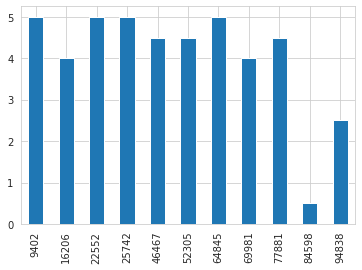

In [97]:
#The different ratings for the itemId 89904
df.loc[df['itemID'] == 89904]['rating'].plot(kind = 'bar')

From the above plot it seems most of the ratings this item recieved are between 4 and 5. Only two users of the 11 rated the item below 4.  It seems that for each prediction, the users are some kind of outliers and the item has been rated very less number of times.

Therefore, the next step is to fins an optimal number of items to recommend to the users

### Part 2.1 K Recommendations

When it comes to recommending items in a recommender syste,, we are highly interested in recommending only the top K items to the user and to find the optimal number recall and precision used.

1. Precsion: Makes an attempt to answer 'What propotions of positive identifications by the model are literally correct?'
2. Recall: Makes an attempt to answer the question of what propotion of actual positives were known properly by the model.

Therfore, in order to use precision and recall as the evaluation metric the ratings which are scaled between 0-5 , need to be converted into a binary format. Relevant or Irrelevant items based on a set threshold.




Setting an arbitrary threshold at 3.5 such that:

**Relevant:** True Rating > = 3.5

**Irrelevant:** True Rating < 3.5


**Recommended item:** Predicted Rating > = 3.5

**Not Recommended item:** Predicted Rating > = 3.5

Given that in recommendation systems, the interest is to show the top N items to users rather than all the items. Therefore it is best to compute precision and recall on top N values instead of caluclating on all the items.

**Therefore, recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.**

However, in cases where we want to obtain an optimal blend of precision and recall, we can use **F1** score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

**f1 score = 2 * (precision * recall) / (precision + recall)**

In [99]:
#defining function for computing recall, precision and F1 score
final = []

for threshold in np.arange(0, 5.5, 0.5):
  tp=0  #true positive
  fn=0  #false negative
  fp=0  #false positive
  tn=0  #true negative
  temp = []

  for uid, _, true_r, est, _ in predictions:
    if(true_r>=threshold):
      if(est>=threshold):
        tp = tp+1
      else:
        fn = fn+1
    else:
      if(est>=threshold):
        fp = fp+1
      else:
        tn = tn+1   

    if tp == 0:
      precision = 0
      recall = 0
      f1 = 0
    else:
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)
      f1 = 2 * (precision * recall) / (precision + recall)  

  temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
  final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,25209,0,0,0,1.000000,1.000000,1.000000
1,0.5,25209,0,0,0,1.000000,1.000000,1.000000
2,1.0,24843,365,1,0,0.985520,1.000000,0.992707
3,1.5,24084,1106,12,7,0.956094,0.999709,0.977415
4,2.0,23562,1450,112,85,0.942028,0.996405,0.968454
5,2.5,21320,2693,702,494,0.887852,0.977354,0.930456
6,3.0,18193,2420,2387,2209,0.882598,0.891726,0.887139
7,3.5,10766,2722,7078,4643,0.798191,0.698683,0.745129
8,4.0,4058,898,12260,7993,0.818805,0.336736,0.477215
9,4.5,457,223,19629,4900,0.672059,0.085309,0.151400


From the results above, the optimal threshold value is 2.5

The next step is to find the optimal K value, and to find it we have to first calculate precision and recall for all the K values(2-10) having threshold value 2.5.

Below is the function to calculate **precision and recall @ K.**

In [100]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls
    

In [101]:
#gettin the evaluation results
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results

[{'K': 2, 'Precision': 0.9466338259441708, 'Recall': 0.174642846611795},
 {'K': 3, 'Precision': 0.9392446633825948, 'Recall': 0.24924538221726206},
 {'K': 4, 'Precision': 0.9373289545703337, 'Recall': 0.31809883477901413},
 {'K': 5, 'Precision': 0.9354406130268209, 'Recall': 0.3777324409105694},
 {'K': 6, 'Precision': 0.934893267651888, 'Recall': 0.43166319543822806},
 {'K': 7, 'Precision': 0.931765579795135, 'Recall': 0.4785135284740033},
 {'K': 8, 'Precision': 0.9289506607240594, 'Recall': 0.5176647334989506},
 {'K': 9, 'Precision': 0.9254613339588721, 'Recall': 0.5513858642538473},
 {'K': 10, 'Precision': 0.9228158313133674, 'Recall': 0.5798380316962117}]

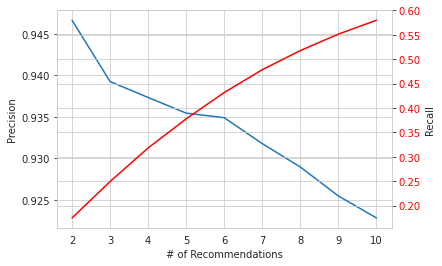

In [102]:
#plotting the number of recommendations against recall and precision.
Rec=[]
Precision=[]
Recall=[]
for i in range(0,9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

from matplotlib import pyplot as plt
#plotting the precision
plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
#plotting recall
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')
for tl in plt2.get_yticklabels():
    tl.set_color('r')

From the above graph, we can observe that the precision drops significantly when K=6. Therfore, we'll consider our optimal number of recommendations to be 6.

Having the optiumum number of movies to recommend, the next step is to give recommendation to the users. Therefore, we have to predict ratings for the movies which the user has not yet watched.

In [146]:
#training the SVD algorithm on the entire daatset with the movie titles and genre
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors=factors, n_epochs=epochs, lr_all=lr_value, reg_all=reg_value)
algo.fit(trainset)

In [147]:
#predicting the ratings for all pairs of (users and items) that are not in the training set
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

In [191]:
#model evaluation
accuracy.rmse(predictions)

RMSE: 0.6331


0.6330593789009233

In [149]:
#sorting the ratings
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

In [150]:
#all predictions
all_pred = get_all_predictions(predictions)

In [151]:
#Getting the top 6 movies,K=6
n = 6
for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]

In [152]:
# creating a dataframe for allpreds
tmp = pd.DataFrame.from_dict(all_pred)
tmp.head(2)

,196,186,22,244,166,298,115,253,305,6,62,286,200,210,224,303,122,194,291,234,119,167,299,308,95,38,102,63,160,50,301,225,290,97,157,181,278,276,7,10,...,895,906,900,908,916,911,912,914,918,919,921,910,913,915,922,923,928,927,924,929,931,917,932,909,934,933,935,938,940,888,925,942,937,926,943,939,936,930,920,941
0,"(1449, 4.548167357959338)","(1449, 4.51049304507169)","(357, 4.694175851738358)","(127, 4.860296869523846)","(174, 4.762437114247539)","(1449, 4.760490328732902)","(179, 4.994427236447383)","(174, 4.690218690207548)","(1449, 4.291956908356786)","(1449, 4.350290308859978)","(408, 4.374318766302123)","(1449, 4.960376155645555)","(1449, 5)","(1449, 4.928278208857879)","(174, 4.196458419058281)","(1449, 4.669651050870197)","(1449, 4.778807244700173)","(1449, 4.001353706085731)","(169, 4.92917090987714)","(408, 3.9690213692608136)","(1449, 4.884296350562099)","(1449, 4.495330954913992)","(1449, 4.41518209383194)","(1449, 4.733709412969011)","(318, 4.5285404585706335)","(143, 5)","(1449, 3.8045105408843094)","(1449, 4.248150319943274)","(1449, 4.814540730823887)","(1449, 4.5755509351729655)","(169, 4.504325941521384)","(408, 5)","(313, 4.206480600406568)","(1449, 4.660726992483971)","(318, 4.905810956382338)","(313, 3.030144095202606)","(1449, 4.993322220496063)","(1449, 4.68029111996645)","(1449, 4.956794156672521)","(1449, 4.936230944609473)",...,"(408, 4.820500083676069)","(1449, 4.817503176584514)","(1449, 3.587226203103974)","(1449, 4.228140161626313)","(1449, 4.508333568736594)","(1449, 4.670726478353418)","(1449, 4.453800647991633)","(1449, 4.234504339147412)","(1449, 4.150457077154214)","(1449, 4.579905884401838)","(1449, 4.177503979241791)","(1449, 4.160086951605724)","(1449, 4.288472073928596)","(318, 4.061758026072446)","(318, 4.402555412697584)","(474, 5)","(474, 5)","(1449, 4.721568345813297)","(1449, 4.442567764360825)","(1449, 4.2456718004973615)","(318, 4.640189853307916)","(408, 4.6656998565903205)","(408, 4.719392801025256)","(483, 5)","(64, 4.494680120713434)","(408, 3.820085875586316)","(1449, 4.807359452232617)","(174, 4.5587804336830455)","(1449, 4.301249775892012)","(408, 5)","(1449, 4.416398148516605)","(64, 5)","(1449, 4.207431666253267)","(408, 4.284014290611213)","(1449, 4.449399905216067)","(98, 5)","(1449, 4.9536404759382116)","(1449, 3.9162986106764275)","(169, 4.263163307099551)","(1449, 4.843074931998053)"
1,"(169, 4.431226571470888)","(174, 4.501913707864521)","(318, 4.67749219945764)","(1449, 4.827293165843654)","(50, 4.697575907346352)","(64, 4.71564867589394)","(408, 4.88120257533561)","(1449, 4.6349312826076)","(603, 4.041136785651521)","(603, 4.230485379374268)","(169, 4.314234220767449)","(318, 4.7377613681319035)","(64, 4.958181534131046)","(318, 4.8584694043327)","(64, 4.120727589083047)","(180, 4.572749409645796)","(169, 4.707957034307114)","(169, 3.9343893543069233)","(1449, 4.915319288998331)","(169, 3.894721444180295)","(408, 4.803658227741258)","(64, 4.398692761181647)","(64, 4.2244027062151766)","(114, 4.6717741081950095)","(1449, 4.375092427831901)","(966, 4.868711829928769)","(408, 3.7086681607831036)","(169, 4.169277499746241)","(134, 4.659749473750155)","(318, 4.428356905819597)","(1449, 4.4505441481276895)","(169, 5)","(1449, 4.2051575623616495)","(64, 4.5548294708963555)","(169, 4.834074237363111)","(318, 2.929764461315576)","(318, 4.903767350223366)","(114, 4.648098764653428)","(408, 4.80878848142554)","(318, 4.8826805726767155)",...,"(1449, 4.815703868079714)","(318, 4.698831985176859)","(64, 3.4774369726309233)","(64, 4.124069437651888)","(127, 4.470525314788033)","(169, 4.579117868233857)","(408, 4.283102388344217)","(169, 4.2208652062241905)","(408, 4.123396667348451)","(169, 4.404561701012058)","(64, 4.125482762270667)","(64, 4.116144099290363)","(178, 4.136622927717299)","(408, 4.059357772051258)","(1449, 4.3048413435273)","(603, 5)","(603, 5)","(408, 4.583869512816733)","(483, 4.317873637460595)","(64, 4.140683047534146)","(1449, 4.590337632108459)","(1449, 4.644

In [177]:
#transpose
tmp_transpose = tmp.transpose()
tmp_transpose.head()


,0,1,2,3,4,5
196,"(1449, 4.548167357959338)","(169, 4.431226571470888)","(408, 4.43033148547254)","(64, 4.358736803992443)","(318, 4.354213534891502)","(114, 4.3524064566305185)"
186,"(1449, 4.51049304507169)","(174, 4.501913707864521)","(64, 4.473351714581163)","(22, 4.414192188435609)","(318, 4.384096707378675)","(408, 4.368121856623893)"
22,"(357, 4.694175851738358)","(318, 4.67749219945764)","(169, 4.593715105327577)","(408, 4.566423868979636)","(302, 4.564486402655507)","(483, 4.510742157820108)"
244,"(127, 4.860296869523846)","(1449, 4.827293165843654)","(408, 4.759797840159388)","(134, 4.7462285107860875)","(474, 4.734563886301147)","(178, 4.718694994472022)"
166,"(174, 4.762437114247539)","(50, 4.697575907346352)","(318, 4.641165849507214)","(22, 4.631902194305563)","(172, 4.605645646597172)","(64, 4.597940205434604)"


In [169]:
tmp_transpose.info()

<class 'pandas.core.frame.DataFrame'>
Index: 943 entries, 196 to 941
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       943 non-null    object
 1   1       943 non-null    object
 2   2       943 non-null    object
 3   3       943 non-null    object
 4   4       943 non-null    object
 5   5       943 non-null    object
dtypes: object(6)
memory usage: 91.6+ KB


In [154]:
# creating a function for querrying the movie recommendations
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [155]:
#testing the function
user_id='196'
results = get_predictions(user_id)
results

0    (1449, 4.548167357959338)
1     (169, 4.431226571470888)
2      (408, 4.43033148547254)
3      (64, 4.358736803992443)
4     (318, 4.354213534891502)
5    (114, 4.3524064566305185)
Name: 196, dtype: object

The above results are the movie recommendations for user 196. The tuple contains the Movie_Id and the predicted rating. Since we just need the movie_id, we'll need to extract this from the results. 

In [156]:
#redefiing the function
recommended_movie_ids=[] #function for holding the movie_ids
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    #iterating through the recommendations
    for x in range(0, n):
      recommended_movie_ids.append(results[x][0])
    return recommended_movie_ids


In [157]:
get_predictions('196')

['1449', '169', '408', '64', '318', '114']

In [158]:
#getting the movie details
movie_titles.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [159]:
#redefining the funtion to return the movie_titles
def get_predictions(user_id):
    """
    args:
      user_id : the index, with a string datatype
    """
    recommended_movie_ids=[] #function for holding the movie_ids
    results = tmp_transpose.loc[user_id]
    #iterating through the recommendations
    for x in range(0, n):
      recommended_movie_ids.append(results[x][0])
    recommended_movies = movie_titles[movie_titles['movieId'].isin(recommended_movie_ids)]
    return recommended_movies

In [188]:
get_predictions('196')

,movieId,title,genres
57,64,Two if by Sea (1996),Comedy|Romance
141,169,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
353,408,8 Seconds (1994),Drama
1113,1449,Waiting for Guffman (1996),Comedy


We can check the user's history to check whehther we are recommending the right movies.

In [186]:
#defining function to get user history
def get_history(user_id):
  '''
  args:
    user_id: The user_id takes an interger value
  '''
  #the movies the user has watched before
  temp = ratings_df[ratings_df['userId'] == user_id].sort_values('rating',ascending=False)
  user_history = movie_titles[movie_titles['movieId'].isin(temp['movieId'])]
  return user_history[:n] #return top n movies for the user


In [187]:
#checking the user's history
get_history(196)

,movieId,title,genres
55,62,Mr. Holland's Opus (1995),Drama
92,104,Happy Gilmore (1996),Comedy
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
398,457,"Fugitive, The (1993)",Thriller


From the above, we can observe that the recurring genre in Drama, Comedy and Adventure. We can check for one more user. User 166

In [189]:
get_predictions('166')

,movieId,title,genres
21,22,Copycat (1995),Crime|Drama|Horror|Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
57,64,Two if by Sea (1996),Comedy|Romance
144,172,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller
146,174,Jury Duty (1995),Comedy
277,318,"Shawshank Redemption, The (1994)",Crime|Drama


In [190]:
#checking the user's history
get_history(166)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,6,Heat (1995),Action|Crime|Thriller
9,10,GoldenEye (1995),Action|Adventure|Thriller
16,17,Sense and Sensibility (1995),Drama|Romance
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


The recurring genre in the above prediction and history is Thriller, which seems to have been predicted well.

We can therefore conclude that the model performs quite well in recommending the movies a user might be interested in.

**References**:
1. https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54
2. https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
3. https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall?hl=ru
4.  https://surprise.readthedocs.io/en/stable/
